In [1]:
from src import PINNViga
from src import Carga
from src import Apoio
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
import time

VIGA BIAPOIADA

In [2]:
## SEÇÃO DA VIGA

b = 0.2
h = 0.4
E = 30e9
I = b * (h ** 3) / 12
EI = E * I

In [3]:
# VIGA BIAPOIADA
# CRIANDO OS APOIOS

L = 2

## CRIANDO OS APOIOS

apoio_esq = Apoio.Apoio([1, 1, 0], [0, 0])
apoio_dir = Apoio.Apoio([0, 1, 0], [L, 0])

## CRIANDO CARGAS

p = -10e3
q = p / (0.1 * L)

# q1 = Carga.CargaDistribuida([0, q], [0.45 * L, 0], [0.55 * L, 0])
# q2 = Carga.CargaDistribuida([0, -10e3], [L / 2, 0], [L, 0])
q3 = Carga.CargaDistribuida([0, -20e3], [0, 0], [L, 0])
# q3 = Carga.CargaDistribuida([0, -20e3], [0.4 * L, 0], [0.6 * L, 0])

cargas = [q3]
# cargas = [q1, q2, q3]

In [4]:
trechos_cargas = {

}

for carga in cargas:
    print(vars(carga))

{'qx': 0, 'qy': -20000.0, 'x0': 0, 'y0': 0, 'x1': 2, 'y1': 0}


In [5]:
valores_x = []

for carga in cargas:
    if carga.x0 not in valores_x:
        valores_x.append(carga.x0)
    if carga.x1 not in valores_x:
        valores_x.append(carga.x1)

for apoio in [apoio_esq, apoio_dir]:
    if apoio.x not in valores_x:
        valores_x.append(apoio.x)

valores_x = sorted(valores_x)

print(valores_x)

[0, 2]


In [6]:
trechos_cargas = []

for k in range(len(valores_x) -1):
    dict_trecho = {
        "x0" : valores_x[k],
        "x1" : valores_x[k + 1],
        "qx" : 0,
        "qy" : 0
    }

    for carga in cargas:
        if carga.x0 <= valores_x[k] and carga.x1 >= valores_x[k+1]:
            dict_trecho['qx'] += carga.qx
            dict_trecho['qy'] += carga.qy

            # print(carga.x0, valores_x[k])
            # print(carga.x1, valores_x[k + 1])

            print(f"{carga.x0} <= {valores_x[k]}")
            print(f"{carga.x1} >= {valores_x[k + 1]}")

    trechos_cargas.append(dict_trecho)
pd.DataFrame(trechos_cargas)

0 <= 0
2 >= 2


,x0,x1,qx,qy
0,0,2,0,-20000.0


In [7]:
max_qy = max([carga['qy'] for carga in trechos_cargas])
print(max_qy)

-20000.0


In [8]:
## LOOP DE TREINAMENTO

biapoiada = PINNViga.PINNViga()
biapoiada.run_model(apoio_esq, apoio_dir, cargas, EI, L, num_epochs=2000, pde_weight=1, bc_weight=1, tol = 1e-10)

Epoch 0, Loss: 1.584760785103, PDE Loss: 1.565947294235, BC Loss: 0.018813548610
Epoch 200, Loss: 0.001172476681, PDE Loss: 0.001123526832, BC Loss: 0.000048949834
Epoch 400, Loss: 0.000052194886, PDE Loss: 0.000051793973, BC Loss: 0.000000400914
Epoch 600, Loss: 0.000036886202, PDE Loss: 0.000036861893, BC Loss: 0.000000024308
Epoch 800, Loss: 0.000030670941, PDE Loss: 0.000030662261, BC Loss: 0.000000008680
Epoch 1000, Loss: 0.000026549988, PDE Loss: 0.000026545049, BC Loss: 0.000000004938
Epoch 1200, Loss: 0.000321990316, PDE Loss: 0.000313968951, BC Loss: 0.000008021376
Epoch 1400, Loss: 0.000020897562, PDE Loss: 0.000020894966, BC Loss: 0.000000002595
Epoch 1600, Loss: 0.000018282422, PDE Loss: 0.000018279234, BC Loss: 0.000000003189
Epoch 1800, Loss: 0.000016531792, PDE Loss: 0.000016527718, BC Loss: 0.000000004075
Epoch 2000, Loss: 0.000014444071, PDE Loss: 0.000014442869, BC Loss: 0.000000001202
Melhor estado restaurado da época 1898 com perda 1.521098e-05


In [9]:
biapoiada.trechos_cargas

[{'x0': 0, 'x1': 2, 'qx': 0, 'qy': -20000.0}]

In [10]:
max_qy = max([abs(carga['qy']) for carga in biapoiada.trechos_cargas])
max_qy

20000.0

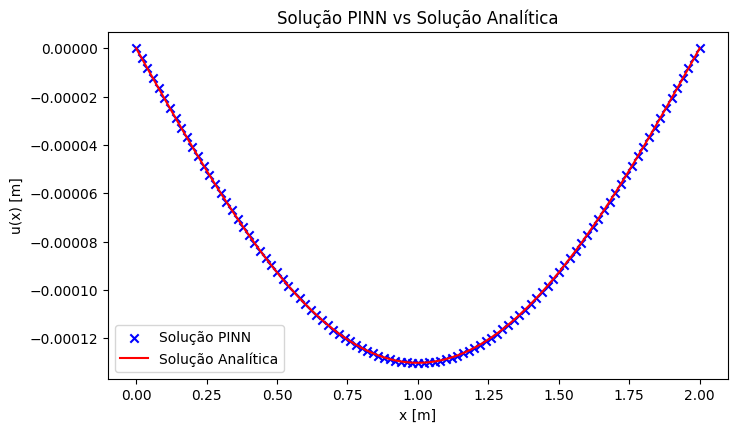

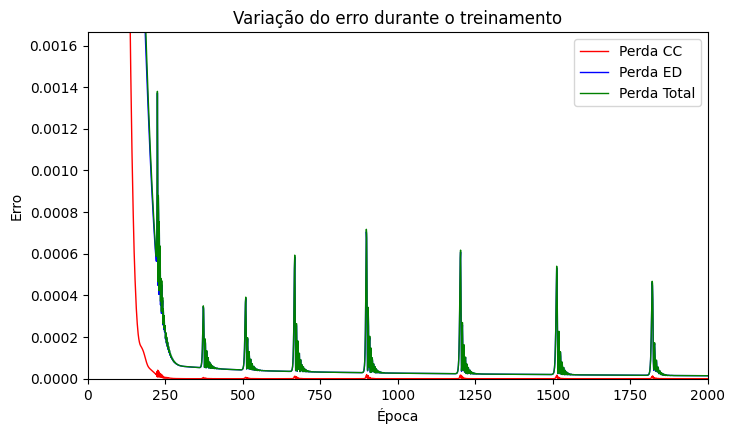

In [11]:
def y_calc(x_val): 
    return (q * x_val / (24 * EI)) * (L**3 - 2 * L * x_val**2 + x_val**3)

q = -20e3
# def y_calc(x_val):
#     y_val = []
#     for x in x_val:
#         if x <= (L / 2):
#             x_ = x
#         else:
#             x_ = max(x_val) - x
#         #     y =  (fy * x / (48 * EI)) * (4 * (x ** 2) - 3 * L ** 2)
#         # else:
#         #     y =  (fy * x / (48 * EI)) * (- 4 * (x ** 2) + 12 * L * x ** 2 - 9 * (L ** 2) * x + L ** 3)

#         y =  - (p / (48 * EI)) * (4 * (x_ ** 3) - 3 * (L ** 2) * x_)
        
#         y_val.append(y)

#     return y_val

plt.figure(figsize=(8, 4.5))
plt.scatter(biapoiada.x_plot, biapoiada.u_plot, label='Solução PINN', marker='x', color='blue')
plt.plot(biapoiada.x_plot, y_calc(biapoiada.x_plot), label='Solução Analítica', color='red')
plt.title("Solução PINN vs Solução Analítica")
plt.xlabel("x [m]")
plt.ylabel("u(x) [m]")
plt.legend()
plt.grid(False)
plt.savefig('deflexao_biapoiada.png', dpi=300)
plt.show()

biapoiada.plot_errors(1000, "erros_biapoiada.png")

In [13]:
# from matplotlib.animation import FuncAnimation, PillowWriter

# fig, ax = plt.subplots(figsize=(8, 4.5))

# ax.set_title("Verificação da convergência")
# ax.set_xlabel("Posição (m)")
# ax.set_ylabel("Deflexão (m)")
# ax.grid(True)
# ax.set_xlim(0, 3)
# ax.set_ylim(min(biapoiada.u_plot) + 0.05 * min(biapoiada.u_plot), max(biapoiada.u_plot) + 0.05 * max(biapoiada.u_plot))
# ax.legend()

# line_pinn, = ax.plot([], [], 'b-', label='Solução PINN')
# line_analytic, = ax.plot(biapoiada.x_plot, y_calc(biapoiada.x_plot), 'r--', label='Solução Analítica')

# u_plot_variation_reduced = biapoiada.u_plot_variation[::2]

# def animate(i):

#     epoch, u_pinn = u_plot_variation_reduced[i]
#     line_pinn.set_data(biapoiada.x_plot, u_pinn)
#     ax.set_title(f"Verificação da convergência - Época {epoch}")
    
#     return line_pinn,

# anim = FuncAnimation(fig, animate, frames=len(u_plot_variation_reduced), interval=50, blit=True)
# writer = PillowWriter(fps=30)
# anim.save("post_biapoiada.gif", writer=writer)

# plt.show()